In [ ]:
import tensorflow as tf
import tensorflow.python.saved_model
import matplotlib.pyplot as plt
import numpy as np
import os
import keras

from keras.models import Sequential, Model
from keras.layers import Conv2D, UpSampling2D, Input
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize
from skimage import img_as_ubyte
from skimage import io, color
from skimage.io import imsave

#### DATA IMPORTATION

In [ ]:
input_size = 128
path = '/content/drive/MyDrive/colorization/'
input_directory = path + 'color/'
epoch = 1000
batch_size =128

# configuration for display image
input_images = np.asarray([x for x in os.listdir(input_directory) if x.endswith('.jpg')])
np.random.shuffle(input_images)
num_inputs = len(input_images)

print('Input size; ', num_inputs)

Input size;  100


In [ ]:
def get_examples(indices):
  output = np.zeros((input_size, input_size, 3, len(indices)), 'uint8')

  for i, n in enumerate(indices):
    im = io.imread(input_directory + input_images[n])
    output[:, :, :, i] = im

  return output

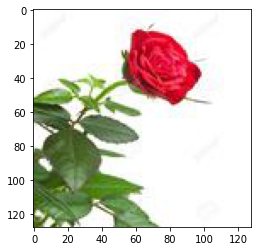

In [ ]:
index = np.random.choice(num_inputs, 2)
examples = get_examples(index)
im = examples[:, :, :, 0]
plt.imshow(im)

#### BUILDING VGG16 ARCHITECTURE MODEL AS ENCORDER

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
vggmodel = VGG16()
newmodel = Sequential()

In [ ]:
for i, layer in enumerate(vggmodel.layers):
  if i < 19:
    newmodel.add(layer)
  newmodel.summary()

for layer in newmodel.layers:
  layer.trainable = False

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 

#### DATASETS PROCESSING 

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
train = train_datagen.flow_from_directory(path, target_size=(224, 224), batch_size=len(input_images), class_mode=None)

Found 120 images belonging to 4 classes.


In [ ]:
X = []
Y = []

for img in train[0]:
  try:
    lab = rgb2lab(img)
    X.append(lab[:, :, 0])
    Y.append(lab[:, :, 1] / 128)
  
  except:
    print('error')

X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape + (1,))

print(X.shape)
print(Y.shape)

(100, 224, 224, 1)
(100, 224, 224)


#### BUILDING DECORDER LAYERS

In [ ]:
vggfeatures = []

for i, sample in enumerate(X):

  sample = gray2rgb(sample)
  sample = sample.reshape((1, 224, 224, 3))
  prediction = newmodel.predict(sample)
  prediction = prediction.reshape((7, 7, 512))
  vggfeatures.append(prediction)

vggfeatures = np.array(vggfeatures)
print(vggfeatures.shape)

(100, 7, 7, 512)


In [ ]:
#Decoder
model = Sequential()

model.add(Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=(7, 7, 512)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(2, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.summary()

print('Layer No.: ' + str(len(model.layers)))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 7, 7, 256)         1179904   
                                                                 
 conv2d_13 (Conv2D)          (None, 7, 7, 128)         295040    
                                                                 
 up_sampling2d_10 (UpSamplin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 64)        73792     
                                                                 
 up_sampling2d_11 (UpSamplin  (None, 28, 28, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 32)       

In [ ]:
model.compile(optimizer='Adam', loss='mse', metrics=['accuracy'])

In [ ]:
model.save('autoencoder_imagecolorization.h5')

#### TESTING AND LOADING MODEL

In [ ]:
model = tf.keras.models.load_model('autoencoder_imagecolorization.h5', custom_objects=None, compile=True)

In [ ]:
testpath = '/content/drive/MyDrive/colorization/test/'
files = os.listdir(testpath)

for idx, file in enumerate(files):

  test = img_to_array(load_img(testpath + file))
  test = resize(test, (224, 224), anti_aliasing=True)
  test *= 1.0/255
  lab = rgb2lab(test)
  l = lab[:, :, 0]
  L = gray2rgb(l)
  L = L.reshape((1, 224, 224, 3))
  vggpred = newmodel.predict(L)
  ab = model.predict(vggpred)
  ab = ab * 128
  cur = np.zeros((224, 224, 3))
  cur[:, :, 0] = l
  cur[:, :, 1:] = ab
  imsave('/content/drive/MyDrive/colorization/vgg_result/' + str(idx) + '.jpg', img_as_ubyte(lab2rgb(cur)))

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 7417 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 11876 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 15636 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 5889 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 12399 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserW

In [ ]:
!jupyter nbconvert --to html WIENER_Filters_5_sample_images.ipynb

[NbConvertApp] Converting notebook WIENER_Filters_5_sample_images.ipynb to html
[NbConvertApp] Writing 4111972 bytes to WIENER_Filters_5_sample_images.html
